In [1]:
import torch
import torch.nn as nn
from torch.nn import Linear
from torch import optim
import os
import pandas as pd
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from mpl_toolkits import mplot3d
%matplotlib inline
torch.set_printoptions(linewidth=150)
import math

### Plotting the data for a single cup

In [2]:
dataset = pd.read_csv('D:/JOB, Application STUFF/Fraunhofer/Frauhofer task/Takk 3/Example_Data.csv', sep=';', decimal=',')
n=len(dataset)
print("size of dataset is ", n)
m=2043
a=int(n/m)
print("the size of geometric points for each cup is ",m)

size of dataset is  900963
the size of geometric points for each cup is  2043


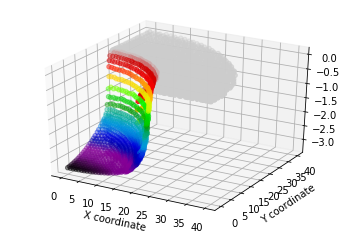

In [3]:
fig = plt.figure()
x = dataset.loc[0:2043,'X']
#print(x.shape)
y = dataset.loc[0:2043,'Y']
z = dataset.loc[0:2043,'Z']
ax = fig.add_subplot(projection='3d')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
#print(z.shape)
ax.scatter3D(x, y, z, c=z, cmap='nipy_spectral')
plt.show() 

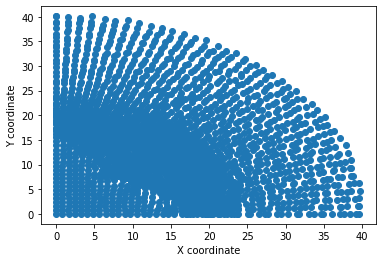

In [4]:
fig = plt.figure()
x = dataset.loc[0:2043,'X']
#print(x.shape)
y = dataset.loc[0:2043,'Y']
z = dataset.loc[0:2043,'Z']
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
xi = np.array(x)
yi= np.array(y)
plt.scatter(xi,yi)
plt.show() 
#print(xi)

## Calculate the hidden size for Refnet by Cupnet

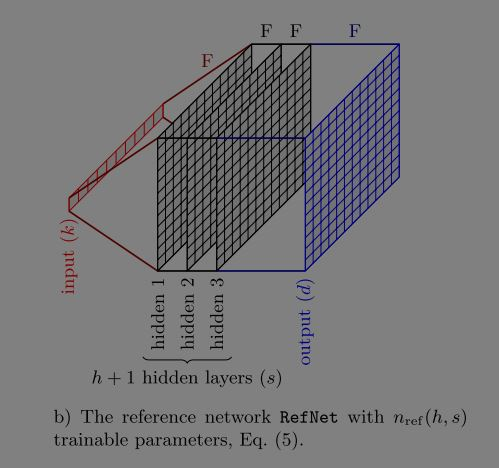

In [5]:
from IPython.display import Image
Image(filename="C:/Users/sneha/Capture.JPG", width=400)

### Data Processing

In [72]:
from torch.utils.data import Dataset, DataLoader
   


class Dataset(Dataset):
    def __init__(self, transform=None):
        super(Dataset,self).__init__()
        self.data_name=pd.read_csv('D:/JOB, Application STUFF/Fraunhofer/Frauhofer task/Takk 3/Example_Data.csv', sep=';', decimal=',')
        self.x = torch.tensor(self.data_name[['A','B']].values.reshape(441,-1,2)[:,1,:].astype('float32'))
        print("size of input is ",self.x.size())
        #X, Y, Z are outputs
        X = self.data_name['X'].values.reshape(441,2043)
        Y = self.data_name['Y'].values.reshape(441,2043)
        Z = self.data_name['Z'].values.reshape(441,2043)
        self.y = torch.from_numpy(np.concatenate((X,Y,Z),axis=1).astype('float32'))
        
        print("size of output is ",self.y.size())
        self.transform=transform 
        print(self.data_name.head())
        self.len = self.x.shape[0]
        
    def __len__(self):
        return self.len
     
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
data = Dataset()

#print("size of the data is ",len(data))
sample = data[:][1]
print(sample.shape)

#splitting data into train and vaidation

val_size = 41
train_size = len(data) - val_size
train_ds, val_ds = random_split(data, [train_size, val_size])
print("the train size is {} and validation size is {} ".format(len(train_ds), len(val_ds)))

batch_size = 100
train_loader = DataLoader(train_ds, batch_size,num_workers=8 shuffle=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=8) 


#for x,y in train_loader:
    #print(x.shape)


size of input is  torch.Size([441, 2])
size of output is  torch.Size([441, 6129])
   NODE             X          Y         Z     A      B  Number Experiment
0     1 -1.060000e-14  40.048313  0.000021 -0.01 -0.001                  1
1     2  1.582933e+00  39.936877 -0.000020 -0.01 -0.001                  1
2     3  3.137810e+00  39.648188 -0.000137 -0.01 -0.001                  1
3     4  4.728823e+00  40.078871  0.000057 -0.01 -0.001                  1
4     5  6.312642e+00  39.612751 -0.000137 -0.01 -0.001                  1
torch.Size([441, 6129])
the train size is 400 and validation size is 41 


### Creating Pruning matrix and Distance Matrix

In [131]:
D = np.zeros((m,m))
for i in range (m):
    for j in range (m):
        D[i,j] = np.sqrt((((xi[i]-xi[j])**2)+(yi[i]-yi[j])**2))
#print(D)   

### Calculate the hidden size for Refnet by Cupnet

In [161]:
def hidden(alpha, h, d):
    C = np.ones((m,m))
    for i in range(m):
        for j in range(m):
            if(D[i,j]>alpha):
                C[i,j]=0
    #C = torch.tensor(C)
    #print(C)
    c_alpha_sum = C.sum()
    u = in_size + h + d + 1
    n_cup = ((in_size*d + d)+  3*h*(int(c_alpha_sum) + m) + 3*(m**2 + m))
    s = int((-u + math.sqrt(u**2 - 4*h*(d-(int(n_cup)))/(2*h))))
    n_ref = (((in_size*s) + s) + h*(s**2 + s) + (s*d + d)) 
    #print("Total trainable parameter in Ref net is ", n_ref)
    #print("Total tainable paramter in cup net is ",n_cup)
    print("Hidden layer size of Refnet is ",s)
    return C,s



### Defining the Model

In [11]:
class My_Model(nn.Module):
    def __init__(self, in_size, alpha, h, d, p=0):
        
        super(My_Model,self). __init__()
        self.in_size = in_size
        self.alpha = alpha
        self.h = h
        self.d = d
        #calling hidden function
        self.hidden_obj,self.s = hidden(self.alpha, self.h,self.d)
        self.hidden=nn.ModuleList()
        self.drop=nn.Dropout(p=p)
        self.Layers = [in_size, *[self.s for i in range(h)], 6129]
        print(self.Layers)
        for input_size,output_size in zip(self.Layers, self.Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
            
    def forward(self, activation):
        L=len(self.hidden)
        for(l,linear_transform) in zip(range(L),self.hidden):
            if l<L-1:
                activation=torch.relu(linear_transform(activation))
                activation=self.drop(activation)
            else:
                activation= linear_transform(activation)
        return activation

### Training

In [170]:
from sklearn.metrics import r2_score

#accesing the weights of the optimised model
#print(model.parameters())
#print(model.state_dict()['hidden.0.weight'])#[hidden.weight]
#print(model.state_dict()['hidden.1.weight'].shape)
#model.state_dict()['hidden.1.weight'] = model.state_dict()['hidden.1.weight']*hidden_obj


def train(model,train_loader, val_loader, optimizer, epochs=20):
    total_loss = {'training_loss':[],'validation_loss':[]}
    for epoch in range(epochs):
        batch_loss=[]
        for x,y in train_loader:
            optimizer.zero_grad()
            yhat = model(x) 
            loss = MSE(y,yhat)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())  
        total_loss['training_loss'].append(torch.Tensor(batch_loss).mean().item())
    
        batch_loss=[]        
        for x,y in val_loader:
            optimizer.zero_grad()
            yhat = model(x) 
            loss = MSE(y,yhat)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            total_loss['validation_loss'].append(torch.Tensor(batch_loss).mean().item()) 
        if total_loss['training_loss'][epoch]>total_loss['training_loss'][epoch-1] and total_loss['validation_loss'][epoch]>total_loss['validation_loss'][epoch-1]:
            break
    return total_loss


### single model loss

In [211]:
in_size = 2 
d = 2043*3 
alpha = 1
h = 1
torch.manual_seed(55)

MSE = nn.MSELoss()
model = My_Model(in_size, alpha, h,d, p=0.20)
optimizer = optim.Adam(model.parameters(), lr=5E-2, weight_decay= 1e-3)
total_loss= train(model,train_loader, val_loader, optimizer)

for training_loss,validation_loss in zip(total_loss['training_loss'],total_loss['validation_loss']):
    print('training_loss:{:.2f},     validation_loss:{:.2f}'.format(training_loss,validation_loss))

    


Hidden layer size of Refnet is  1790
[2, 1790, 6129]
training_loss:178.33,     validation_loss:27.23
training_loss:99.56,     validation_loss:4.20
training_loss:89.08,     validation_loss:2.70
training_loss:87.80,     validation_loss:1.52
training_loss:87.60,     validation_loss:1.93
training_loss:87.60,     validation_loss:1.79
training_loss:87.80,     validation_loss:1.76
training_loss:87.80,     validation_loss:1.96


### to find best learning rate
https://github.com/davidtvs/pytorch-lr-finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.11E-07


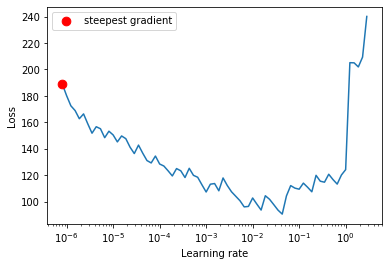

In [203]:
from torch_lr_finder import LRFinder

#def LRfinder():
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, MSE, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


In [185]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

in_size = 2
d = 2043*3     #depth of hidden layer
seed_list = np.random.randint(60,99999,10)
print("random seeds are = {}".format(seed_list))
alpha_list = [1,2.5,5,10,25,50]
#h =  number of hidden layers

for alpha in alpha_list:
    for h in range (1,7,1):
        for seed in seed_list:
            torch.manual_seed(seed)Helmholtz-Zentrum Dresden Rossendorf, Bautzner Landstraße 400, 01328 Dresden
            print("alpha = {}, hidden layer = {} seed = {}" .format(alpha,h,seed))
            MSE = nn.MSELoss()
            model = My_Model(in_size, alpha, h,d, p=0.20)
            #r2_score = r2score(model)
            optimizer = optim.Adam(model.parameters(), lr=6.89E-04, weight_decay= 1e-1)
            total_loss= train(model,train_loader, val_loader, optimizer)
            for training_loss,validation_loss in zip(total_loss['training_loss'],total_loss['validation_loss']):
                print('training_loss:{:.2f},     validation_loss:{:.2f}'.format(training_loss,validation_loss)) 
end.record()
torch.cuda.synchronize()
print("time taken to run this program is {:0.4f} seconds" .format(start.elapsed_time(end)))

random seeds are = [76684 86728 48351 19514 68167 48275 30650 54546  4927 51683]
alpha = 1, hidden layer = 1 seed = 76684
Hidden layer size of Refnet is  1790
[2, 1790, 6129]
training_loss:112.11,     validation_loss:25.64
training_loss:111.81,     validation_loss:25.15
training_loss:111.67,     validation_loss:24.93
training_loss:111.41,     validation_loss:25.23
training_loss:110.91,     validation_loss:24.17
training_loss:110.89,     validation_loss:23.99
training_loss:110.65,     validation_loss:24.37
training_loss:110.13,     validation_loss:23.79
training_loss:110.06,     validation_loss:23.02
training_loss:109.75,     validation_loss:23.01
training_loss:109.60,     validation_loss:23.01
training_loss:109.20,     validation_loss:22.35
training_loss:109.13,     validation_loss:22.70
training_loss:108.80,     validation_loss:22.43
training_loss:108.53,     validation_loss:21.64
training_loss:108.50,     validation_loss:22.02
training_loss:108.26,     validation_loss:21.36
training_

training_loss:102.70,     validation_loss:16.20
training_loss:102.79,     validation_loss:16.33
alpha = 1, hidden layer = 5 seed = 68167
Hidden layer size of Refnet is  1813
[2, 1813, 1813, 1813, 1813, 1813, 6129]
training_loss:102.70,     validation_loss:16.13
training_loss:102.69,     validation_loss:16.18
training_loss:102.64,     validation_loss:15.98
training_loss:102.63,     validation_loss:16.17
training_loss:102.65,     validation_loss:15.92
training_loss:102.54,     validation_loss:16.39
training_loss:102.60,     validation_loss:16.15
training_loss:102.67,     validation_loss:16.00
training_loss:102.68,     validation_loss:16.32
alpha = 1, hidden layer = 5 seed = 48275
Hidden layer size of Refnet is  1813
[2, 1813, 1813, 1813, 1813, 1813, 6129]
training_loss:102.65,     validation_loss:16.13
training_loss:102.67,     validation_loss:16.23
alpha = 1, hidden layer = 5 seed = 30650
Hidden layer size of Refnet is  1813
[2, 1813, 1813, 1813, 1813, 1813, 6129]
training_loss:102.71, 

[2, 1905, 1905, 1905, 1905, 6129]
training_loss:102.77,     validation_loss:16.40
training_loss:102.53,     validation_loss:16.35
training_loss:102.74,     validation_loss:16.14
training_loss:102.55,     validation_loss:15.97
training_loss:102.77,     validation_loss:16.15
alpha = 2.5, hidden layer = 4 seed = 30650
Hidden layer size of Refnet is  1905
[2, 1905, 1905, 1905, 1905, 6129]
training_loss:102.68,     validation_loss:16.42
training_loss:102.53,     validation_loss:16.40
training_loss:102.84,     validation_loss:16.13
training_loss:102.56,     validation_loss:16.46
training_loss:102.63,     validation_loss:16.10
training_loss:102.61,     validation_loss:16.15
training_loss:102.64,     validation_loss:16.00
training_loss:102.54,     validation_loss:16.46
training_loss:102.65,     validation_loss:16.26
training_loss:102.58,     validation_loss:15.96
training_loss:102.67,     validation_loss:16.27
alpha = 2.5, hidden layer = 4 seed = 54546
Hidden layer size of Refnet is  1905
[2, 

Hidden layer size of Refnet is  2113
[2, 2113, 2113, 2113, 6129]
training_loss:102.68,     validation_loss:16.61
training_loss:102.43,     validation_loss:16.23
training_loss:102.69,     validation_loss:16.20
training_loss:102.64,     validation_loss:15.41
training_loss:102.76,     validation_loss:16.49
alpha = 5, hidden layer = 3 seed = 48275
Hidden layer size of Refnet is  2113
[2, 2113, 2113, 2113, 6129]
training_loss:102.62,     validation_loss:16.09
training_loss:102.67,     validation_loss:16.52
alpha = 5, hidden layer = 3 seed = 30650
Hidden layer size of Refnet is  2113
[2, 2113, 2113, 2113, 6129]
training_loss:102.64,     validation_loss:16.03
training_loss:102.54,     validation_loss:16.39
training_loss:102.67,     validation_loss:16.25
training_loss:102.54,     validation_loss:16.43
training_loss:102.69,     validation_loss:16.05
training_loss:102.61,     validation_loss:16.30
training_loss:102.55,     validation_loss:16.05
training_loss:102.68,     validation_loss:16.12
alp

Hidden layer size of Refnet is  2498
[2, 2498, 2498, 6129]
training_loss:102.67,     validation_loss:16.19
training_loss:102.59,     validation_loss:16.14
training_loss:102.61,     validation_loss:16.43
alpha = 10, hidden layer = 2 seed = 19514
Hidden layer size of Refnet is  2498
[2, 2498, 2498, 6129]
training_loss:102.56,     validation_loss:16.36
training_loss:102.72,     validation_loss:16.28
training_loss:102.36,     validation_loss:16.17
training_loss:102.84,     validation_loss:16.39
alpha = 10, hidden layer = 2 seed = 68167
Hidden layer size of Refnet is  2498
[2, 2498, 2498, 6129]
training_loss:102.62,     validation_loss:16.34
training_loss:102.51,     validation_loss:16.18
training_loss:102.72,     validation_loss:16.53
alpha = 10, hidden layer = 2 seed = 48275
Hidden layer size of Refnet is  2498
[2, 2498, 2498, 6129]
training_loss:102.64,     validation_loss:16.49
training_loss:102.56,     validation_loss:16.50
training_loss:102.73,     validation_loss:16.05
training_loss:

training_loss:102.67,     validation_loss:16.15
training_loss:102.55,     validation_loss:16.24
training_loss:102.49,     validation_loss:16.69
training_loss:102.64,     validation_loss:15.99
training_loss:102.65,     validation_loss:15.80
training_loss:102.66,     validation_loss:16.02
alpha = 25, hidden layer = 1 seed = 86728
Hidden layer size of Refnet is  2971
[2, 2971, 6129]
training_loss:102.63,     validation_loss:16.22
training_loss:102.70,     validation_loss:16.14
training_loss:102.64,     validation_loss:16.09
training_loss:102.83,     validation_loss:16.23
alpha = 25, hidden layer = 1 seed = 48351
Hidden layer size of Refnet is  2971
[2, 2971, 6129]
training_loss:102.79,     validation_loss:15.86
training_loss:102.60,     validation_loss:16.31
training_loss:102.66,     validation_loss:16.05
training_loss:102.64,     validation_loss:16.36
training_loss:102.52,     validation_loss:16.11
training_loss:102.64,     validation_loss:16.13
alpha = 25, hidden layer = 1 seed = 19514


[2, 6659, 6659, 6659, 6659, 6659, 6129]
training_loss:102.68,     validation_loss:15.93
training_loss:102.52,     validation_loss:16.54
training_loss:102.67,     validation_loss:16.08
training_loss:102.57,     validation_loss:16.26
training_loss:102.70,     validation_loss:16.21
training_loss:102.72,     validation_loss:16.11
training_loss:102.53,     validation_loss:16.38
training_loss:102.55,     validation_loss:15.88
training_loss:102.66,     validation_loss:16.13
alpha = 25, hidden layer = 5 seed = 30650
Hidden layer size of Refnet is  6659
[2, 6659, 6659, 6659, 6659, 6659, 6129]
training_loss:102.68,     validation_loss:15.95
training_loss:102.65,     validation_loss:16.22
training_loss:102.65,     validation_loss:16.16
training_loss:102.39,     validation_loss:16.25
training_loss:102.84,     validation_loss:15.83
training_loss:102.62,     validation_loss:16.48
training_loss:102.55,     validation_loss:16.10
training_loss:102.71,     validation_loss:16.11
alpha = 25, hidden layer 

training_loss:102.79,     validation_loss:16.13
training_loss:102.60,     validation_loss:16.10
training_loss:102.64,     validation_loss:16.30
alpha = 50, hidden layer = 4 seed = 30650
Hidden layer size of Refnet is  6628
[2, 6628, 6628, 6628, 6628, 6129]


KeyboardInterrupt: 

### Calculate R squared score

In [200]:

from sklearn.metrics import r2_score

def r2score(model):
    x = data[:][0][0]#work on the indexes
    y = data[:][1][0]
    yhat= model(x)
    yhat = yhat.detach().numpy()
    
    
    r2_score22 = r2_score(y,yhat)
    #print(MSE)
    print(r2_score22)
    #print("R2 score  = {}".format(r2_score_cal))

r2_score = r2score(model)


0.8579488678207335


In [199]:
def r2score(model):
    x = data[:][0][0]
    y = data[:][1][0]
    yhat= model(x)
    yhat = yhat.detach().numpy()
    
    for i in range (len(y)):
        MSE = ((y[i]-yhat[i])**2).sum()
    for i in range (len(data)):
        tss = (((data[:][1][i] - data[:][1].mean())**2).sum())#index issue
    r2_score_cal = (tss - MSE)/tss
    
    
    #print(MSE)
    print("R2 score  = {}".format(r2_score_cal))

r2_score = r2score(model)



R2 score  = 0.01471201702952385


In [ ]:
useless LRfinder find the steepest decent
issue with r2 score
add files to cudo server
issue with the input and y values

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
print(device)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x,y in data]
    return data.to(device, non_blocking=True)

